In [66]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import shap
import functions as feature

X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_test = X_test.reset_index(drop=True)

X_train_means = X_train.mean().to_frame().T

COLUMNS = X_train.columns

nn = MLPRegressor(solver="adam", alpha=1e-1, hidden_layer_sizes=(10, 10, 5), random_state=0)
nn.fit(X_train, y_train)

def print_accuracy(f):
    print(
        f"Root mean squared test error = {np.sqrt(np.mean((f(X_test) - y_test) ** 2))}"
    )
    time.sleep(0.5)  # to let the print get out before any progress bars

print_accuracy(nn.predict)

Root mean squared test error = 0.5661689302959705


  0%|          | 0/1 [00:00<?, ?it/s]

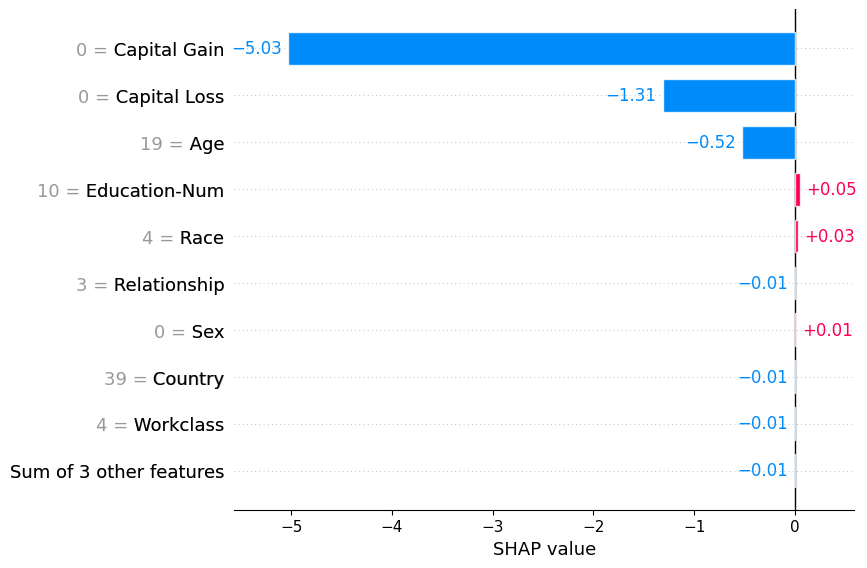

In [83]:
# explain all the predictions in the test set
# select only first entry of X_test
item = X_test.iloc[[9]]

shap_values = feature.calc_shap_values(item, X_train_means, nn, COLUMNS)
shap.plots.bar(shap_values[0])

  0%|          | 0/1 [00:00<?, ?it/s]

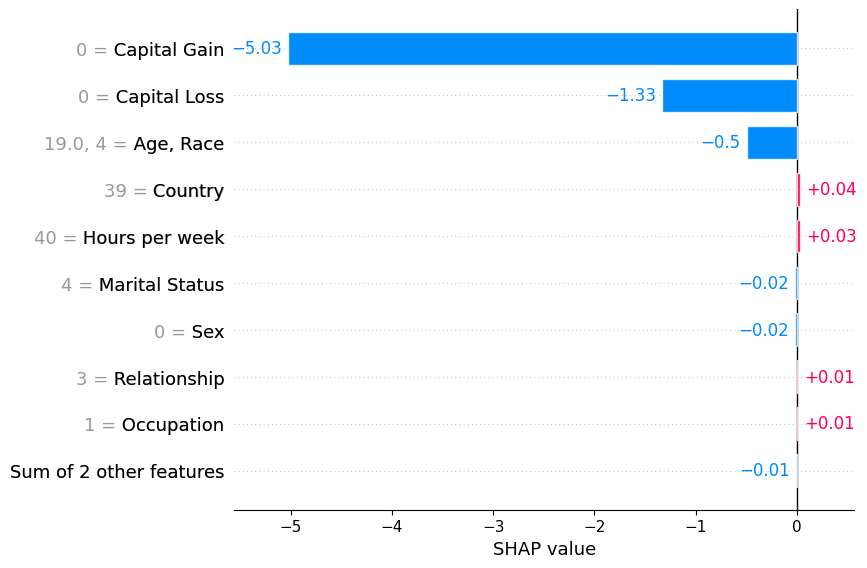

In [84]:
#entangle the named columns
COL_LIST = ['Age', 'Race']

tmp_X_test = feature.combine_columns(X_test.copy(), COL_LIST)
tmp_X_train_means = feature.combine_columns(X_train_means.copy(), COL_LIST)

item = tmp_X_test.iloc[[9]]
shap_values = feature.calc_shap_values(item, tmp_X_train_means, nn, COLUMNS)
shap.plots.bar(shap_values[0])